In [1]:
import os
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from sklearn.model_selection import train_test_split

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Read in and format raw data

In [2]:
# read in raw dataset
rawDataset = pd.read_csv("WEOOct2021all.csv")
rawDataset

,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,1980,...,2018,2019,2020,2021,2022,2023,2024,2025,2026,Estimates Start After
0,512,AFG,NGDP_R,Afghanistan,"Gross domestic product, constant prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,270.22","1,319.90","1,288.87",NaN,NaN,NaN,NaN,NaN,NaN,2019.0
1,512,AFG,NGDP_RPCH,Afghanistan,"Gross domestic product, constant prices",Annual percentages of constant price GDP are y...,Percent change,NaN,"See notes for: Gross domestic product, consta...",NaN,...,1.189,3.912,-2.351,NaN,NaN,NaN,NaN,NaN,NaN,2019.0
2,512,AFG,NGDP,Afghanistan,"Gross domestic product, current prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,327.69","1,469.60","1,547.29",NaN,NaN,NaN,NaN,NaN,NaN,2019.0
3,512,AFG,NGDPD,Afghanistan,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,18.401,18.876,20.136,NaN,NaN,NaN,NaN,NaN,NaN,2019.0
4,512,AFG,PPPGDP,Afghanistan,"Gross domestic product, current prices",These data form the basis for the country weig...,Purchasing power parity; international dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,77.406,81.873,80.912,NaN,NaN,NaN,NaN,NaN,NaN,2019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8818,698,ZWE,BCA,Zimbabwe,Current account balance,Current account is all transactions other than...,U.S. dollars,Billions,Source: Reserve Bank of Zimbabwe and Ministry ...,-0.301,...,-1.38,0.92,1.275,1.262,1.06,0.621,0.148,-0.247,-0.683,2019.0
8819,698,ZWE,BCA_NGDPD,Zimbabwe,Current account balance,Current account is all transactions other than...,Percent of GDP,NaN,"See notes for: Gross domestic product, curren...",NaN,...,-5.867,4.699,5.815,4.894,3.811,2.217,0.519,-0.833,-2.162,2019.0
8820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8821,"International Monetary Fund, World Economic Ou...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Compile dict of WEO Subject Code to description
codesDict = {}
codes = rawDataset[["WEO Subject Code","Subject Descriptor","Units"]]
for weocode in pd.unique(codes["WEO Subject Code"])[:-1]:
    codesDict[weocode] = codes[codes.values == weocode]['Subject Descriptor'].iloc[0] + \
        " (" + codes[codes.values == weocode]['Units'].iloc[0] + ")"

In [4]:
# Isolate only the two relevent descriptor columns (ISO and WEO Subject Code) and the year of the data
dataset = rawDataset[["Country","WEO Subject Code","Estimates Start After"] + list(rawDataset.columns)[9:-1]]

# Remove predicted data from dataset
#for year in range(int(dataset["Estimates Start After"].min()),2026):
#    dataset.loc[dataset["Estimates Start After"] < year, str(year)] = np.nan

# Remove Estimates Start After column
dataset = dataset.drop(columns="Estimates Start After")

# Melt all year columns into a single column
dataset = dataset.melt(id_vars=['Country', "WEO Subject Code"], var_name='Year',value_name='Value')

# Pivot table so that it is indexed by the values in Country and WEO Subject code and columned by year
dataset = dataset.pivot_table(index=["Country","WEO Subject Code"],columns='Year',values='Value',aggfunc='first',dropna=False)

# Turn all data into float64
dataset = dataset.replace(',','', regex=True)
dataset = dataset.replace('(-)+','', regex=True)
dataset = dataset.replace(r'^\s*$', np.nan, regex=True)
dataset = dataset.astype('float64')

dataset.columns = dataset.columns.astype('int64')

Gross domestic product, constant prices (National currency)


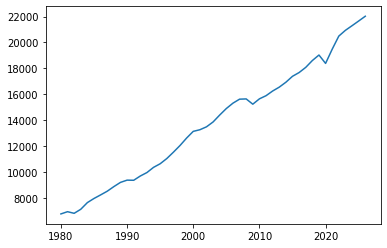

In [5]:
print(codesDict["NGDP_R"])
plt.plot(dataset.columns,dataset.loc["United States", "NGDP_R"])

# Data Preprocessing

In [6]:
'''
def trim_dataset(dataset, cutoff=4000,timeSeriesWidth=10):
    # Define how many data points are required for a statistic to be used and 
    # how long of a time series time series and an output time series we are going to be doing

    # Get the list of both levels of index
    countries = list(dataset.index.levels[0])
    codes = list(dataset.index.levels[1])

    # Sum up the total number of time series of len timeSeriesWidth for each code over all countries and sort
    results = []
    for code in codes:
        s = 0
        for country in countries:
            s += max(dataset.loc[country, code].count() - timeSeriesWidth, 0)
        results.append((code, s))
    results.sort(key=lambda tup: tup[1],reverse=True)

    # Trim all codes that have less than the cutoff from the dataset
    trimmedDataset = dataset.copy()
    for result in results:
        if result[1] < cutoff:
            trimmedDataset = trimmedDataset.drop(index=result[0], level=1)

    # Trim all countries that do not have a time series of len timeSeriesWidth with all the accepted codes
    for country in countries:
        if (trimmedDataset.loc[country].isna().sum() == 0).sum() < timeSeriesWidth:
            trimmedDataset = trimmedDataset.drop(index=country, level=0)
    
    return trimmedDataset
'''

'\ndef trim_dataset(dataset, cutoff=4000,timeSeriesWidth=10):\n    # Define how many data points are required for a statistic to be used and \n    # how long of a time series time series and an output time series we are going to be doing\n\n    # Get the list of both levels of index\n    countries = list(dataset.index.levels[0])\n    codes = list(dataset.index.levels[1])\n\n    # Sum up the total number of time series of len timeSeriesWidth for each code over all countries and sort\n    results = []\n    for code in codes:\n        s = 0\n        for country in countries:\n            s += max(dataset.loc[country, code].count() - timeSeriesWidth, 0)\n        results.append((code, s))\n    results.sort(key=lambda tup: tup[1],reverse=True)\n\n    # Trim all codes that have less than the cutoff from the dataset\n    trimmedDataset = dataset.copy()\n    for result in results:\n        if result[1] < cutoff:\n            trimmedDataset = trimmedDataset.drop(index=result[0], level=1)\n\n    

In [7]:
def create_time_series(dataset, timeSeriesWidth=10):
    
    # Get the list of both levels of index
    countries = list(dataset.index.levels[0])
    codes = list(dataset.index.levels[1])
    
    columns = list(range(dataset.columns[0] + timeSeriesWidth-1,dataset.columns[-1]))
    
    timeSeries = pd.DataFrame(index=pd.MultiIndex.from_product(
                [countries, codes, list(range(timeSeriesWidth))],
                names=["Country", "WEO Subject Code", "Year"]
            ), columns=columns, dtype='float64').rename_axis('End Year', axis=1)

    
    for country in countries:
        for code in codes:
            if (country,code) not in dataset.index:
                continue
            for year in range(timeSeriesWidth):
                timeSeries.loc[(country,code,year)] = \
                    list(dataset.iloc[dataset.index.get_loc((country,code)),(year):(-timeSeriesWidth + year)])
                
    return timeSeries

In [8]:
def split_time_series(timeSeriesData, inputWidth=9, labelWidth=1, inputParams=None, labelParams=None):
    if len(list(timeSeriesData.index.levels[2])) != inputWidth + labelWidth:
        return None, None
    if inputParams == None:
        inputParams=timeSeriesData.index.levels[1]
    if labelParams == None:
        labelParams=timeSeriesData.index.levels[1]
    
    #create label data and remove it from the input data
    labelData = timeSeriesData.xs(inputWidth, level=2,drop_level=False)
    timeSeriesData = timeSeriesData.drop(index=inputWidth, level=2)
    for year in range(inputWidth + 1, inputWidth+labelWidth):
        labelData = pd.concat([labelData, timeSeriesData.xs(year, level=2,drop_level=False)], axis=0)
        timeSeriesData = timeSeriesData.drop(index=year, level=2)
        
    # Trim down input and label codes
    for code in timeSeriesData.index.levels[1]:
        if code not in inputParams:
            timeSeriesData = timeSeriesData.drop(index=code, level=1)
        if code not in labelParams:
            labelData = labelData.drop(index=code, level=1)

    return timeSeriesData, labelData

In [9]:
def normalize_input(data, params):
    
    countries = list(dataset.index.levels[0])
    
    meanDict = {}
    stdDict = {}
    
    for code in params:
         meanDict[code] = data.xs(code, level=1).stack().mean()
         stdDict[code] = data.xs(code, level=1).stack().std()
        
    for country in countries:
        for code in params:
            data.loc[country,code].apply(lambda x: (x - meanDict[code]) / stdDict[code])

    return data
    

In [10]:
def make_tf_dataset(inputData, labelData, inputWidth=9, labelWidth=1):
    """
    
    """
    inputArray = []
    labelArray = []
    
    countries = list(inputData.index.levels[0])
    codes = list(labelData.index.levels[1])
    
    for country in countries:
        countryInputSlice = inputData.xs(country, level=0,drop_level=False)
        countryLabelSlice = labelData.xs(country, level=0,drop_level=False)
        for endYear in range(min(inputData.columns), max(inputData.columns) + 1):
            endYearInputSlice = countryInputSlice[endYear]
            endYearLabelSlice = countryLabelSlice[endYear]
            
            # separate inputs by year relative to "endYear"
            yearlyInputs = []
            for year in range(inputWidth):
                i = endYearInputSlice.xs(year,level=2,drop_level=False).values
                yearlyInputs.append(list(i))
            
            # seperate labels by year relative to "endYear"
            yearlyLabels = []
            for year in range(inputWidth, inputWidth + labelWidth):
                l = endYearLabelSlice.xs(year,level=2,drop_level=False).values
                yearlyLabels.append(list(l))
                
            # create label 
            if np.isnan(yearlyInputs).sum() == 0 and np.isnan(yearlyLabels).sum() == 0:
                    inputArray.append(yearlyInputs)
                    labelArray.append(yearlyLabels)
                
    inputDs = tf.data.Dataset.from_tensor_slices(inputArray).batch(32)
    labelDs = tf.data.Dataset.from_tensor_slices(labelArray).batch(32)
    return tf.data.Dataset.zip((inputDs, labelDs))

In [11]:
def train_validate_test_split(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True):
    assert (train_split + test_split + val_split) == 1
    shuffle_size=10000
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=0)
    
    ds_size = len(ds)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [12]:
def prepare_dataset(dataset=dataset, inputWidth=9, labelWidth=1, train_split=0.8, val_split=0.1,
        test_split=0.1, shuffle=True, randomState=0, inputParams=['PPPGDP'], labelParams=['PPPGDP']):
    
    #trimmedDataset = trim_dataset(dataset, 5000, inputWidth + labelWidth)
    timeSeriesData = create_time_series(dataset, inputWidth + labelWidth)
    inputData, labelData = split_time_series(timeSeriesData, inputWidth=inputWidth, labelWidth=labelWidth,
            inputParams=inputParams,labelParams=labelParams)
    inputData = normalize_input(inputData, inputParams)
    ds = make_tf_dataset(inputData, labelData, inputWidth, labelWidth)
    train_ds, val_ds, test_ds = train_validate_test_split(ds, train_split=0.8, val_split=0.1, 
            test_split=0.1, shuffle=True)
    return train_ds, val_ds, test_ds

# Plot code

In [13]:
def plot(train_ds, numGraphs, param):
    plt.figure(figsize=(12, 8))

    plot_col_index = self.column_indices[plot_col]
    i = 1
    for inputData, label in train_ds.take(numGraphs):
        plt.subplot(numGraphs, 1, n+1)
        i += 1
        
        plt.ylabel(f'{param} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [relative]')


# Model Construction

In [14]:
MAX_EPOCHS = 20

def compile_and_fit(model, train_ds, val_ds, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(train_ds, epochs=MAX_EPOCHS,
                      validation_data=val_ds,
                      callbacks=[early_stopping])
  return history

In [15]:
linear = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1])
])

train_ds, val_ds, test_ds = prepare_dataset(
    dataset=dataset,
    inputWidth=9,
    labelWidth=1,
    train_split=0.8,
    val_split=0.1,
    test_split=0.1,
    shuffle=True,
    randomState=0,
    inputParams=['PPPGDP'],
    labelParams=['PPPGDP'])

history = compile_and_fit(linear, train_ds, val_ds)

print(linear.evaluate(val_ds))
print(linear.evaluate(test_ds, verbose=0))

Epoch 1/20
160/160 [==============================] - 1s 1ms/step - loss: 8401696.0000 - mean_absolute_error: 810.4805 - val_loss: 3269994.2500 - val_mean_absolute_error: 889.2593
Epoch 2/20
160/160 [==============================] - 0s 844us/step - loss: 11676874.0000 - mean_absolute_error: 832.5400 - val_loss: 1550108.2500 - val_mean_absolute_error: 500.4831
Epoch 3/20
160/160 [==============================] - 0s 841us/step - loss: 2164769.2500 - mean_absolute_error: 556.7410 - val_loss: 29925412.0000 - val_mean_absolute_error: 1616.1177
Epoch 4/20
160/160 [==============================] - 0s 815us/step - loss: 8361650.0000 - mean_absolute_error: 712.7424 - val_loss: 227343.6406 - val_mean_absolute_error: 207.6417
Epoch 5/20
160/160 [==============================] - 0s 870us/step - loss: 3864029.0000 - mean_absolute_error: 551.5633 - val_loss: 1819024.7500 - val_mean_absolute_error: 406.0309
Epoch 6/20
20/20 [==============================] - 0s 674us/step - loss: 261797.5469 - me

In [16]:
dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1])
])

history = compile_and_fit(dense, train_ds, val_ds)

print(dense.evaluate(val_ds))
print(dense.evaluate(test_ds, verbose=0))

Epoch 1/20
160/160 [==============================] - 0s 1ms/step - loss: 109724.5391 - mean_absolute_error: 99.4234 - val_loss: 20421.3438 - val_mean_absolute_error: 56.3904
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 13609.6045 - mean_absolute_error: 38.0940 - val_loss: 338869.0625 - val_mean_absolute_error: 154.2003
Epoch 3/20
20/20 [==============================] - 0s 653us/step - loss: 230781.4062 - mean_absolute_error: 166.1759
[230781.40625, 166.17587280273438]
[29958.234375, 81.34455871582031]


In [19]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model, train_ds, val_ds)

print(lstm_model.evaluate(val_ds))
print(lstm_model.evaluate(test_ds, verbose=0))

ValueError: Failed to find data adapter that can handle input: <class 'NoneType'>, <class 'NoneType'>

# Testing :)

In [ ]:
train_ds, val_ds, test_ds = prepare_dataset(
    dataset=dataset,
    cutoff=4000,
    inputWidth=8,
    labelWidth=2,
    train_split=0.8,
    val_split=0.1,
    test_split=0.1,
    shuffle=True,
    randomState=0,
    inputParams=['PPPGDP','NGDP_D'],
    labelParams=['PPPGDP'])

In [ ]:
len(train_ds)

In [ ]:
inputData.xs("United States", level=0,drop_level=False).xs(0,level=2,drop_level=False)[1989].values

In [ ]:
countries = list(dataset.index.levels[0])
codes = list(dataset.index.levels[1])

results = []
for code in codes:
    s = 0
    for country in countries:
        
        s += max(dataset.loc[country, code].count() - 2, 0)
    results.append((code, s))
results.sort(key=lambda tup: tup[1],reverse=True)

for i in range(10):
    print("'" + results[i][0] + "', ", end='')

In [ ]:
# Separate training, validating, and testing data
codesDictd